# <p style="text-align:center">Lecture 5. その他の高度な機能</p>

<p style="text-align:center;font-size:150%;line-height:150%">海津一成</p>

In [1]:
%matplotlib inline
from ecell4 import *

In [2]:
import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
import seaborn
seaborn.set(font_scale=1.5)

## 構造体の形をつくる

E-Cell4は基本的な構造体の形をいくつかサポートしている。

- `PlanarSurface`: 平面
- `Sphere`: 球体
- `Cylinder`: 円柱
- `Rod`: ロッド
- `AABB`: 直方体

In [3]:
help(Rod.__init__)

Help on wrapper_descriptor:

__init__(...)
    Constructor.
    
    Parameters
    ----------
    length : float
        The length of a cylinder part of a rod.
    radius : float
        The radius of a cylinder and sphere caps.
    origin : Real3, optional
        The center position of a rod.



In [4]:
w = spatiocyte.SpatiocyteWorld(Real3(2, 1, 1), 0.01)
w.add_structure(Species('C'), Rod(1, 0.5, Real3(1, 0.5, 0.5)))
viz.plot_world(w)

これらの基本要素に対してその表面だけを構造体とすることもできる。

In [5]:
w = spatiocyte.SpatiocyteWorld(Real3(2, 1, 1), 0.01)
obj = Rod(1, 0.5, Real3(1, 0.5, 0.5))
w.add_structure(Species('C'), obj.surface())
viz.plot_world(w)

これらを組み合せてより複雑な形状をつくることもできる。

- `Union`: ふたつの`Shape`の和で新しい`Shape`をつくる
- `Complement`: ふたつの`Shape`、`X`と`Y`を受けとり、その差（`X-Y`）で新しい`Shape`をつくる
- `AffineTransformation`: 受けとった`Shape`に対して変形操作を行う。今は平行移動とリサイズだけが可能

In [6]:
w = spatiocyte.SpatiocyteWorld(Real3(1.75, 1, 1), 0.01)
obj1 = Sphere(Real3(0.5, 0.5, 0.5), 0.5)
obj2 = Sphere(Real3(1.25, 0.5, 0.5), 0.5)
obj = Union(obj1, obj2)
w.add_structure(Species('C'), obj.surface())
viz.plot_world(w)

## ルールベース・モデリング

### 分子種に構造を持たせる

これまでの分子種の名前は単なる記号であった。

例えば、`A > B`という反応を考えたとき、多くの場合、分種`A`がなんらの修飾状態や構造の変化によって分子種`B`になるのであって分子としては同じ分子であると考えられる。
しかし分子種`A`や`B`といった場合、その分子種間の関係性は明らかではない。

`A + A > B`という反応ではおそらく分子種`B`は`A`分子が2分子結合した二量体だろうと予想できるが`B`という名前からそれはわからない。

こうした問題に対して、分子種に構造を与えるのがルールベース・モデリングの第一歩である。

In [7]:
with reaction_rules():
    # corresponding to 'A > B | 1'
    X(s=u) > X(s=p) | 1

In [8]:
m = get_model()

E-Cell4では括弧や等号を使って分子種の構造を決める。

- 分子種`X(s=u)`は`X`という分子の修飾`s`が状態`u`である。
- 分子種`X(s=p)`は`X`という分子の修飾`s`が状態'p'である。
- この反応は、分子`X`の修飾`s`の状態を`u`から`p`にする。

分子種の構造を`World`で確かめる。

In [9]:
w = gillespie.GillespieWorld()
w.add_molecules(Species('X(s=u)'), 60)
w.add_molecules(Species('X(s=p)'), 120)
print(w.num_molecules(Species('X(s=u)')))
print(w.num_molecules(Species('X(s=p)')))
print(w.num_molecules(Species("X")))

60
120
180


`X`という分子種は1つも追加していないにもかかわらず`num_molecules`で180個という数が得られた。

これは`X`という分子を修飾状態に関わらず全て数え上げているためである。
加えた2つの分子種はどちらも`X`という分子で修飾状態だけが異なる。従って、`X`を数えた場合どちらも当てはまる。

きっちり`X`という名前の分子種だけを数えたい場合は`num_molecules_exact`を使う。

In [10]:
print(w.num_molecules_exact(Species('X(s=u)')))
print(w.num_molecules_exact(Species('X(s=p)')))
print(w.num_molecules_exact(Species("X")))

60
120
0


次に、`X`という分子と`Y`という分子が結合した複合体を表す分子種は以下のように書ける。

In [11]:
with reaction_rules():
    X(b1) + Y(b2) > X(b1^1).Y(b2^1) | 1

In [12]:
m = get_model()

`X`と`Y`がドット`.`で結合されている。このように複合体は複数の分子種をドットでつないで表現する。

`X(b1^1).Y(b2^1)`は全体として一つの分子種を表すが、中に`X(b1^1)`と`Y(b2^1)`という二つの要素が含まれる。E-Cell4ではこれらを単位分子種`UnitSpecies`と呼ぶ。

`X(b1^1).Y(b2^1)`の単位分子種は`b1`、`b2`という修飾を持つ。

これが単位分子種間の結合箇所を決める。`X`と`Y`は各々の修飾`b1`、`b2`を介して結合している。

記号`^`の後の数字は結合箇所の対応を表す数字である。これは対応さえ取れていれば、0より大きなどんな数字でも良い。

左辺の`X(b1)`で修飾`b1`に等号による状態も`^`による結合も記されていないのは、結合箇所`b1`が**誰とも結合していない**ことを明らかにするため。

`X(b1)`は修飾`b1`を介して誰とも結合していない`X`を意味している。

複合体の表現を説明したところで先ほどと同じように試してみる。

In [13]:
w = gillespie.GillespieWorld()

In [14]:
w.add_molecules(Species('X(b1)'), 10)
w.add_molecules(Species('Y(b2)'), 20)
w.add_molecules(Species('X(b1^1).Y(b2^1)'), 30)
print(w.num_molecules(Species('X')))
print(w.num_molecules(Species('Y')))
print(w.num_molecules(Species('X.Y')))

40
50
30


`X`と`Y`は単体と複合体の和になっているのに対して、`X.Y`は複合体だけを数えているのがわかる。

注意点だが、結合部位と修飾部位を両方もつ分子種の場合、

`X(a, b=c)`とは書けるが`X(b=c, a)`とは書けない。

部位が複数ある場合も`X(a, b, c, d=e, f=g)`のように書く必要がある。ただし、順番を入れ替えた`X(c, a, b, f=g, d=e)`は先ほどと同じ意味になる。

### 反応則

先の例では分子種に構造を与えることで分子数を数えることができるようになった。

例えば、数えるときに与えた分子種`X`は具体的な分子種ではなく、数えるべき分子種の条件（「単位分子種にXを含むもの」）を決めた一種のパターンである。

このようなパターンを反応に用いるのが、ルールベース・モデリングの次のステップである。

単位分子種`X`には3つのリン酸化部位`s1`、`s2`、`s3`があり、各々`u`か`p`の二状態のいずれかを独立に取るものとする。

このとき単位分子種`X`のとりえる状態数は$2^3=8$状態となる。

このような分子`X`のリン酸化反応は次のように書ける。

In [15]:
with reaction_rules():
    X(s1=u, s2=u, s3=u) > X(s1=p, s2=u, s3=u) | 1
    X(s1=u, s2=p, s3=u) > X(s1=p, s2=p, s3=u) | 1
    X(s1=u, s2=u, s3=p) > X(s1=p, s2=u, s3=p) | 1
    X(s1=u, s2=p, s3=p) > X(s1=p, s2=p, s3=p) | 1
    X(s1=u, s2=u, s3=u) > X(s1=u, s2=p, s3=u) | 2
    X(s1=p, s2=u, s3=u) > X(s1=p, s2=p, s3=u) | 2
    X(s1=u, s2=u, s3=p) > X(s1=u, s2=p, s3=p) | 2
    X(s1=p, s2=u, s3=p) > X(s1=p, s2=p, s3=p) | 2
    X(s1=u, s2=u, s3=u) > X(s1=u, s2=u, s3=p) | 3
    X(s1=u, s2=p, s3=u) > X(s1=u, s2=p, s3=p) | 3
    X(s1=p, s2=u, s3=u) > X(s1=p, s2=u, s3=p) | 3
    X(s1=p, s2=p, s3=u) > X(s1=p, s2=p, s3=p) | 3

In [16]:
m = get_model()

このように面倒になるのは、各リン酸化反応が独立であることが活かされず、1つのリン酸化部位を考えるのに他の全ての状態を数え上げなければならないからである。

そこで分子種のパターンで考える。

リン酸化部位`s1`に着目したとき、リン酸化反応は分子`X`の`s1`の状態が`u`から`p`から変わることである。
すなわち、`s1`の状態が`u`である分子`X`のパターンに当てはまる分子種をとってきて、その状態を`p`に変えると考える。

In [17]:
with reaction_rules():
    X(s1=u) > X(s1=p) | 1
    X(s2=u) > X(s2=p) | 2
    X(s3=u) > X(s3=p) | 3

これらは個々の具体的な分子種を左右に持った反応ではなく、分子種のパターンを与えるものであるから反応則`ReactionRule`と呼ぶ。

反応則はあくまでもパターンに基づいたルールでしかないため、これだけでは実際にどんな分子種があるのかはわからない。

上の例で言えば左辺に`X(s1=u)`という分子種があるからといってそれが実在するとは限らない。

実際に最初に想定したのは`X(s1=u, s2=u, s3=u)`といった3つの修飾をもった分子種であった。

ルールベース・モデルでは種`seed`となる分子種を与え、そこから繰り返し反応則を適用して出来うる全ての分子種を芋づる的に生成する。ここで種となる分子種は後で`World`に追加する分子種だと思えば良い。

In [18]:
m = get_model(seeds=[Species('X(s1=u, s2=u, s3=u)')])
print(len(m.reaction_rules()))

12


ここで与えた`X(s1=u, s2=u, s3=u)`という種から12の反応が望み通りに得られることがわかる。

このモデルを使って計算してみると、

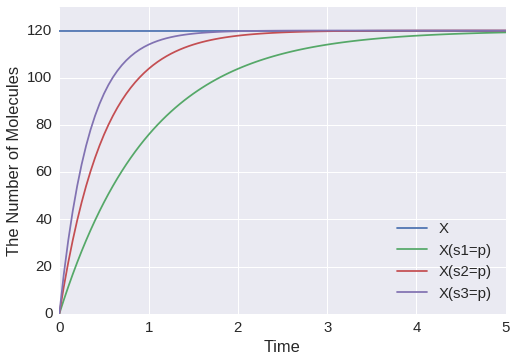

In [19]:
run_simulation(5, y0={'X(s1=u,s2=u,s3=u)': 120}, model=m,
               species_list=('X', 'X(s1=p)', 'X(s2=p)', 'X(s3=p)'),
               opt_kwargs={'ylim': (0, 130)})

### ワイルドカード

分子種`A`に結合部位`b`があったとき「誰とも結合していない`A`」の数が知りたければ`A(b)`とすれば良い。

では、「誰かと**結合している**`A`」はどのように表現すればよいのだろうか？

In [20]:
with reaction_rules():
    A(b) + B(b) > A(b^1).B(b^1) | 1
    A(b^_, s=u) > A(b^_, s=p) | 2

In [21]:
m = get_model()

2つ目の反応則は修飾`s`を`u`から`p`に変えるが、`A`が`b`を介して誰かと結合しているときにしか起こらない.

`_`がワイルド・カード、すなわちどんなものとも合致する記号である。
誰かと結合している`A`は`A(b^_)`と表現される。

修飾にワイルドカードを使うと、

`A(s=_)`は修飾`s`の状態が何であっても良いことを意味する。

何であっても良いならば書く必要ない気もするが、`A`に`s`という修飾があることを保証する。

単位分子種名にワイルドカードを使うと、

`_(s=u)`と書けば状態`u`の修飾`s`を持つどんな分子種にも当てはまる。試すと、

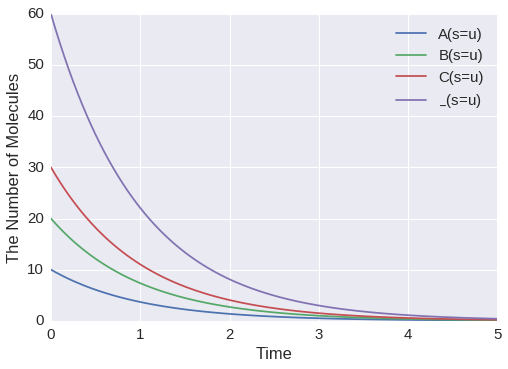

In [22]:
with reaction_rules():
    _(s=u) > _(s=p) | 1

m = get_model(seeds=(
    Species('A(s=u)'), Species('B(s=u)'), Species('C(b^1,s=u).C(b^1,s=u)')))

run_simulation(
    5, y0={'A(s=u)': 10, 'B(s=u)': 20, 'C(b^1,s=u).C(b^1,s=u)': 15}, model=m,
    species_list=('A(s=u)', 'B(s=u)', 'C(s=u)', '_(s=u)'))

分子種の属性を決める場合にもワイルドカードが使える。

In [23]:
with species_attributes():
    _ | {'D': '1', 'radius': '0.005'}

In [24]:
m = get_model()

## 動画を作成する

### viz.plot_movieを使う方法

`World`を可視化するのには`viz.plot_world`が使えた。

これらをつなげて動画にするにはどうすれば良いか？まずは各時刻における状態を`Observer`を使って記録する。

In [25]:
with species_attributes():
    A | {'D': '1', 'location': 'C'}
    B | {'D': '1', 'location': 'N'}
    N | {'location': 'C'}

with reaction_rules():
    A + N > B | 1e-4
    B + C > A | 1e-4

m = get_model()

w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1), 0.005)
w.bind_to(m)
w.add_structure(Species('C'), Sphere(Real3(0.5, 0.5, 0.5), 0.441))
w.add_structure(Species('N'), Sphere(Real3(0.5, 0.5, 0.5), 0.350))
w.add_molecules(Species('A'), 720)

In [26]:
viz.plot_world(w, species_list=('C', 'N'))

全ての状態を保存するには`FixedIntervalHDF5Observer`を使う。

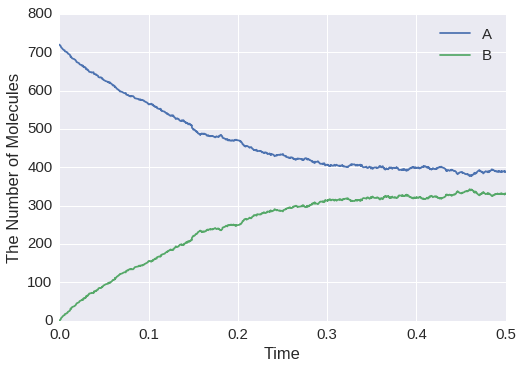

In [27]:
sim = spatiocyte.SpatiocyteSimulator(w)
obs1 = NumberObserver(('A', 'B'))
obs2 = FixedIntervalHDF5Observer(0.01, 'data/sample%03d.h5')
sim.run(0.5, (obs1, obs2))
viz.plot_number_observer(obs1)

あとはこの`Observer`を`viz.plot_movie`で可視化する。

In [28]:
mpl.rcParams.update(inline_rc)

In [29]:
viz.plot_movie(obs2, species_list=('A', 'B'))

In [30]:
import seaborn
seaborn.set(font_scale=1.5)

### ParaViewを使う方法

ParaView（[http://www.paraview.org/](http://www.paraview.org/)）というソフトウェアを使うと動画作成などより詳細な可視化が行える。

- まず前回と同様に`FixedIntervalCSVObserver`で状態をCSV形式で保存する。

In [31]:
with species_attributes():
    A | {'D': '1', 'location': 'C'}
    B | {'D': '1', 'location': 'N'}
    N | {'location': 'C'}

with reaction_rules():
    A + N > B | 1e-4
    B + C > A | 1e-4

m = get_model()

w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1), 0.005)
w.bind_to(m)
w.add_structure(Species('C'), Sphere(Real3(0.5, 0.5, 0.5), 0.441))
w.add_structure(Species('N'), Sphere(Real3(0.5, 0.5, 0.5), 0.350))
w.add_molecules(Species('A'), 720)

In [32]:
sim = spatiocyte.SpatiocyteSimulator(w)
obs = FixedIntervalCSVObserver(0.01, 'data/sample%03d.csv', ('A', 'B'))
sim.run(0.5, obs)

- `File->Open`で保存したCSV形式のデータを選択する。保存した連番のファイルは下図のようにまとめて表示される。読み込んだら左下にある`Properties`で`Apply`ボタンを押す。

<center><img src="images/Figure5-1.png" /></center>

- 読み込んだ後はPipelineによってデータを可視化する。最初にCSVテーブルから座標への変換する。`Filters->Alphabetical->Table To Points`を選択し、左下から`X`, `Y`, `Z Column`として`x`, `y`, `z`を選択し`Apply`ボタンを押す。

<center><img src="images/Figure5-2.png" /></center>

- `Filters->Common->Glyph`を選択する。同様に左下の`Properties`から`Glyph Type`を`Sphere`に、`Scale Mode`を`scalar`にして下の`Scale Factor`横の`Reset using current data values`とヒントの出るボタンを押す。今回は4を入力してApplyボタンを押す。

<center><img src="images/Figure5-3.png" /></center>

- 先ほどの`Properties`に`Coloring`という項目が増えるので`sid`を選ぶ。何も見えなければ左上の`Pipeline Browser`で`Glyph1`の左の目玉がアクティブにする。

<center><img src="images/Figure5-4.png" /></center>

- 上の`Play`ボタンを押す。赤色が増える様子を確認したら`File->Save Animation...`から動画が保存できる。

### ParaViewのマクロを使う方法

以上の作業をあらかじめ登録されたマクロを使って省略できる。CSVファイルをParaViewで読み込むまでは同じ。

- `Macros->Add new macro...`を選び、[https://raw.githubusercontent.com/ecell/ecell4/master/misc/ecell4paraview.py](https://raw.githubusercontent.com/ecell/ecell4/master/misc/ecell4paraview.py)からダウンロードした`ecell4paraview.py`を選択する。

- `Pipeline Browser`で読み込んだCSVファイルを選択してから`Macros->ecell4paraview`を選択する。

## `Factory`の利用

### `Factory`クラスを用いたソルバの切り替え

- `ode`、`gillespie`、`meso`、`lattice`のモジュールを使いわけの違いはほぼ`World`を作るときだけ。
- しかし、`Simulator`の名称や`World`を作る際のオプショナルな引数もある。
- こうした問題を解消するため、各モジュールは`Factory`と呼ばれる便利クラスがある。

`Factory`だけを切り替えることでモジュールが切り替えられる。

In [33]:
factory = ode.ODEFactory()
# f = gillespie.GillespieFactory()
# f = meso.MesoscopicFactory(Integer3(4, 4, 4))
# f = spatiocyte.SpatiocyteFactory(0.005)

w = factory.create_world(Real3(1, 1, 1))
w.bind_to(m)
w.add_molecules(Species('C'), 60)
sim = factory.create_simulator(w)
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

`run_simulation`でも`Factory`を使うことで`spatiocyte`のVoxel半径のような特殊な引数を扱える。

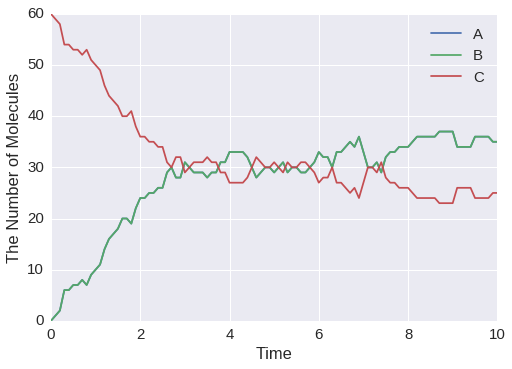

In [34]:
with species_attributes():
    A | B | C | {'D': '1'}

with reaction_rules():
    A + B == C | (0.01, 0.3)

run_simulation(10, {'C': 60}, factory=spatiocyte.SpatiocyteFactory(0.01))

## 練習問題

- **構造体の練習**: `Union`を使って`Rod`を自前で作ってみる。

- **ルールベース・モデリングにおける分子種の練習**: 2つの`X`分子からなる二量体はどのように表現すればよいか。また、`X`の数を数えるときの扱いに関して試す。

- **ルールベース・モデリングにおける反応則の練習**: 二種類の単位分子種`X`と`Y`があり、以下の反応が独立に成立するとき、何通りの分子種が存在するか？

  1. `X`同士は二量体を形成する。
  1. `X`と`Y`は結合する。
  1. `Y`には1つ修飾部位があり、2種類の状態のいずれかをとる。

  ただし、対称性に注意せよ。

- **分子の位置の記録に関する練習**: 今回、`FixedIntervalCSVObserver`でCSV形式のファイルに記録したが、テキストエディタや表計算ソフトなどで開いてみて実際にどのようなことが書き込まれているのか確認する。

- **ParaViewによる可視化に関する練習**: ParaViewは設定によって色々と見栄えが変えられるので自分好みの動画を作ってみる。